In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2

Directory Structure:
- "apples" contains all the provided apple imgs and their masks for training
- "testApples" contains all the provided apple imgs and one mask img for testing
- "partE_apples" contains the two new imgs required by part II section E.
- "partE_masks" contains the masks for the two new imgs in partE_apples.
- Note: apple images are assumed to be in the .jpg format, while masks are assumed to be in the .png format.

## File Loading & Data Prep

In [ ]:
# load img files

train_apples_f = glob.glob("apples/*.jpg")
train_masks_f = glob.glob("apples/*.png")
test_apples_f = glob.glob("testApples/*.jpg")
test_masks_f = glob.glob("testApples/*.png")

# training examples of apples
train_apples = []
# masks for training apples
train_masks = []
# test samples
test_apples = [] 
# masks for test samples
test_masks = [] 

for myFile in train_apples_f:
    im = plt.imread(myFile)
    #h, w = im.shape[0:2]
    #h = int(h*0.25)
    #w = int(w*0.25)
    #im = cv2.resize(im, (w, h), interpolation = cv2.INTER_AREA)
    train_apples.append(im)
for myFile in train_masks_f:
    im = plt.imread(myFile)
    #h, w = im.shape[0:2]
    #h = int(h*0.25)
    #w = int(w*0.25)
    #im = cv2.resize(im, (w, h), interpolation = cv2.INTER_AREA)
    train_masks.append(im)

# test images shrunk to reduce processing time
for myFile in test_apples_f:
    im = plt.imread(myFile)
    h, w = im.shape[0:2]
    h = int(h*0.25)
    w = int(w*0.25)
    im = cv2.resize(im, (w, h), interpolation = cv2.INTER_AREA)
    test_apples.append(im)
for myFile in test_masks_f:
    im = plt.imread(myFile)
    h, w = im.shape[0:2]
    h = int(h*0.25)
    w = int(w*0.25)
    im = cv2.resize(im, (w, h), interpolation = cv2.INTER_AREA)
    test_masks.append(im)

print(train_apples_f)
print(train_masks_f)
print(test_apples_f)
print(test_masks_f)

In [400]:
# turn RGB images from 0-255 to 0-1
for i in range(len(train_apples)):
    train_apples[i] = train_apples[i].astype(np.float32) / 255.
for i in range(len(test_apples)):
    test_apples[i] = test_apples[i].astype(np.float32) / 255.

# form masks of 0s and 1s
for i in range(len(train_masks)):
    train_masks[i] = np.where(train_masks[i][:,:,2] > 0.5, 1, 0)
for i in range(len(test_masks)):
    test_masks[i] = np.where(test_masks[i][:,:,2] > 0.5, 1, 0)

## Mixed Gaussian

In [337]:
def getGaussProb(x,mean,var):   
    # adding small constants to avoid errors such as signular matrix
    var += 1e-6
    temp = (x - mean).T @ np.linalg.inv(var) @ (x - mean)
    temp = np.exp(-0.5 * temp)
    temp2 = np.abs(((2 * np.pi)**(x.size) * np.linalg.det(var+1e-6))**0.5)
    prob = temp / (temp2 + 1e-8)
    return prob                                                    

In [338]:
# taken from the lab code (practicalMixGauss part c) this part was originally in fitMixGauss()
# separates the random init of mix gaussians into another function
def init_mixGauss(k):
    nDims = 3
    mixGaussEst = dict()
    mixGaussEst['d'] = nDims
    mixGaussEst['k'] = k
    mixGaussEst['weight'] = (1 / k) * np.ones(shape=(k))
    mixGaussEst['mean'] = 2 * np.random.randn(nDims, k)
    mixGaussEst['cov'] = np.zeros(shape=(nDims, nDims, k))
    for cGauss in range(k):
        mixGaussEst['cov'][:, :, cGauss] = 2.5 + 1.5 * np.random.uniform() * np.eye(nDims)
    return mixGaussEst

In [830]:
def fitMixGauss(data, k, mixGaussEst):
    nDims, nData = data.shape
    postHidden = np.zeros(shape=(k, nData))
        
    nIter = 20;


    for cIter in range(nIter):

        # ===================== =====================
        # Expectation step
        # ===================== =====================
        curCov = mixGaussEst['cov']                                                                                  
        curWeight = mixGaussEst['weight']                                                                            
        curMean = mixGaussEst['mean']                                                                                

        for cData in range(nData):
            temp = np.zeros(curWeight.shape)
            
            for k_s in range(k):
                prob = getGaussProb(data[:, cData],curMean[:,k_s],curCov[:,:,k_s])
                temp[k_s] = curWeight[k_s] * prob

            postHidden[:, cData] = temp / np.sum(temp)
            
        # ===================== =====================
        # Maximization Step
        # ===================== =====================
        for cGauss in range(k):
            mixGaussEst['weight'][cGauss] = (np.sum(postHidden, axis=1)/np.sum(postHidden))[cGauss]
            mixGaussEst['mean'][:,cGauss] = (np.sum(postHidden[cGauss]*data, axis=1)/np.sum(postHidden[cGauss]))

            temp_means = mixGaussEst['mean'][:,cGauss].reshape(mixGaussEst['mean'][:,cGauss].size, 1)
            mixGaussEst['cov'][:,:,cGauss] = (postHidden[cGauss]*(data-temp_means)@(data-temp_means).T)/np.sum(postHidden[cGauss])

    return mixGaussEst

In [356]:
# apple pixels
acc_1 = []
# non apple pixels
#acc_0 = []
# puts all training pixels into a 3 by nData sized matrix
for img, mask in zip(train_apples, train_masks):
    #temp_0 = np.zeros([3, mask.shape[0]*mask.shape[1]-sum(sum(mask))])
    temp_1 = np.zeros([3, sum(sum(mask))])
    #counter_0 = 0
    counter_1 = 0
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if mask[i, j] == 1:
                temp_1[:, counter_1] = img[i,j,:]
                counter_1 += 1
            #elif mask[i, j] == 0:
            #    temp_0[:, counter_0] = img[i,j,:]
            #    counter_0 += 1
    #acc_0.append(temp_0)
    acc_1.append(temp_1)
data_1 = np.hstack(acc_1)
#data_0 = np.hstack(acc_0)

In [357]:
# batch sampling on the data
# limited number of batches actually used to save on runtime
# ignore the _0 variables since they are not used
np.random.seed(0)

nData_0 = data_0.shape[1]
nData_1 = data_0.shape[1]

batch_size = 300
# compute the number of batches 
n_batches_0 = int(nData_0 / batch_size / 10)
n_batches_1 = int(nData_1 / batch_size / 10)

# generate random idexes of batch size within dataset
random_idx_0 = np.random.choice(nData_0, nData_0, replace=False)
random_idx_1 = np.random.choice(nData_1, nData_1, replace=False)

# split into arrays of indicies, each is a batch
batches_0 = np.array_split(random_idx_0, n_batches_0)
batches_1 = np.array_split(random_idx_1, n_batches_1)

# use 20 batches
batches_0 = batches_0[:20]
batches_1 = batches_1[:25]

In [831]:
np.random.seed(0)
# arbitrary number of gaussians
k = 3
# initializes the gaussians at random
mixGaussEst_1 = init_mixGauss(k)
itr = 0
for batch in batches_1:
    print(itr,'/',len(batches_1))
    itr+=1
    mixGaussEst_1 = fitMixGauss(data_1[:,batch], k, mixGaussEst_1)

0 / 20
1 / 20
2 / 20
3 / 20
4 / 20
5 / 20
6 / 20
7 / 20
8 / 20
9 / 20
10 / 20
11 / 20
12 / 20
13 / 20
14 / 20
15 / 20
16 / 20
17 / 20
18 / 20
19 / 20


## Initial Results

In [832]:
# calculates the pdf under the given mixture of gaussians
def getMixGaussProb(pixel, mixGaussEst):     
    curCov = mixGaussEst['cov']                                                                             
    curWeight = mixGaussEst['weight']                                                                                                                                                  
    curMean = mixGaussEst['mean']
                                                                                                           
    like = 0
    for cGauss in range(mixGaussEst['k']):
        like += curWeight[cGauss]*getGaussProb(pixel,curMean[:,cGauss],curCov[:,:,cGauss])
                                                                                                       
    return like

In [833]:
probs = []
for test_apple in test_apples:
    prob = np.zeros([test_apple.shape[0], test_apple.shape[1]])
    for i in range(test_apple.shape[0]):
        for j in range(test_apple.shape[1]):
            prob_1 = getMixGaussProb(test_apple[i,j,:],mixGaussEst_1)
            prob[i, j] = prob_1
    probs.append(prob)

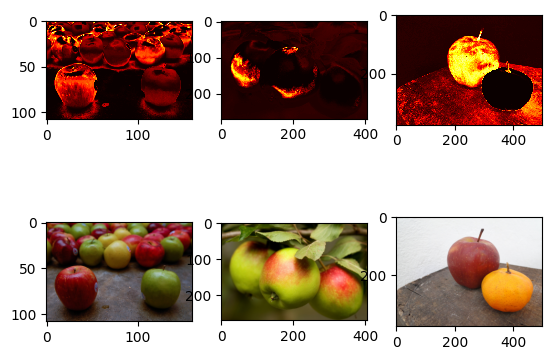

In [834]:
plt.subplot(2, 3, 1)
plt.imshow(probs[0], cmap='hot', interpolation='nearest')
plt.subplot(2, 3, 2)
plt.imshow(probs[1], cmap='hot', interpolation='nearest')
plt.subplot(2, 3, 3)
plt.imshow(probs[2], cmap='hot', interpolation='nearest')
plt.subplot(2, 3, 4)
plt.imshow(test_apples[0])
plt.subplot(2, 3, 5)
plt.imshow(test_apples[1])
plt.subplot(2, 3, 6)
plt.imshow(test_apples[2])

For the image on the left-hand side, the classifier was able to distinguish between apple pixels and non-apple pixels in general. However, certain portions of apples and most shadows were misclassified. For the image in the middle, the classifier only recognized certain shades of green as apple pixels. In particular, brighter reds and darker greens were wrongly classified as non-apple pixels. This might be a result of fewer bright red and dark green apple pixels in the training data. Nevertheless, we cannot be confident that the classifier covers the entire domain of apple pixels in the training set either, since this implementation utilizes batch sampling, as well as only a limited number of batches, to save on training/run time. For the image on the right-hand side, the contrast between apple pixels and non-apple pixels is evident on the heatmap. Certain portions of the desk surface, however, could be misclassified depending on the threshold used.

## Threshold Tuning

In [835]:
# threshold input img, convert to binary, then compare to the mask target
# returns the counted number of TP, TN, FP, FN. Calculates TP Rate, FP Rate.
def count_stats(img, target, threshold):
    n, d = img.shape
    
    # filter by threshold, convert to binary 
    img = np.where(img > threshold, 1, 0)
    target = np.where(target > 0.5, 1, 0)
        
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    for i in range(n):
        for j in range(d):
            r = img[i, j]
            t = target[i, j]
            if r == 1 and t == 1:
                TP += 1
            elif r == 1 and t == 0:
                FP += 1
            elif r == 0 and t == 1:
                FN += 1
            elif r == 0 and t == 0:
                TN += 1
    
    return TP, TN, FP, FN, TP/(TP+FN), FP/(FP+TN)

In [836]:
t_s = (np.arange(70)) / 10
X = []
Y = []
TPs = []
TNs = []
FPs = []
FNs = []
for t in t_s:
    TP, TN, FP, FN, ROC_Y, ROC_X = count_stats(probs[2], test_masks[0], t)
    X.append(ROC_X)
    Y.append(ROC_Y)
    TPs.append(TP)
    TNs.append(TN)
    FPs.append(FP)
    FNs.append(FN)

### Change of True Positives/True Negatives/False Positives/False Negatives with threshold t

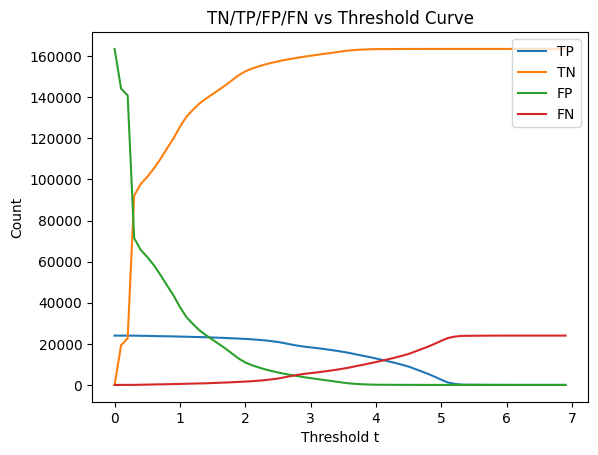

In [837]:
fig,ax = plt.subplots(1)
ax.plot(t_s, TPs, label="TP")
ax.plot(t_s, TNs, label="TN")
ax.plot(t_s, FPs, label="FP")
ax.plot(t_s, FNs, label="FN")
plt.legend(loc="upper right")
plt.title("TN/TP/FP/FN vs Threshold Curve")
plt.xlabel("Threshold t")
plt.ylabel("Count")
plt.show()

### Finding Optimal Threshold t on ROC Curve

In [838]:
# if we weigh false positive and false negative rate equally
idx = np.argmax(np.array(Y) - np.array(X))
print('Optimal t (approximate):', t_s[idx])

Optimal t (approximate): 2.1


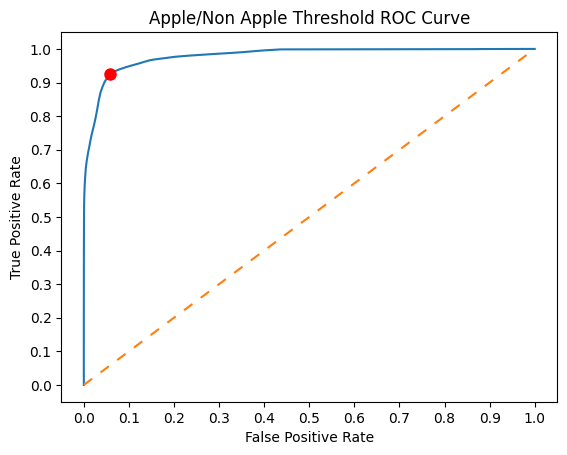

In [839]:
fig,ax = plt.subplots(1)
ax.plot(X, Y)
ticks = list(np.arange(11) / 10)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.plot([0, 1], [0, 1], linestyle='--', dashes=(5, 5))
plt.title("Apple/Non Apple Threshold ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot(X[idx], Y[idx], marker="o", markersize=8, markeredgecolor="red", markerfacecolor="red")
plt.show()

### Confusion Matrix & F Measure of ROC Optimal Threshold t

In [840]:
# stats using optimal t from ROC curve
TP, TN, FP, FN, ROC_Y, ROC_X = count_stats(probs[2], test_masks[0], t_s[idx])
CF = [[TN, FP], [FN, TP]]
precision = TP/(TP+FP)
recall = TP/(TP+FN)
F = 2 * (precision * recall) / (precision + recall)
print('confusion matrix:', CF)
print('F measure:', F)

confusion matrix: [[153903, 9592], [1812, 22193]]
F measure: 0.7955906076357772


### Optimal Threshold t by Optimizing F Meausre

In [841]:
# attempt to find t by maximizing F measure instead
TPs = np.array(TPs)
FPs = np.array(FPs)
precisions = TPs/(TPs+FPs+1e-6)
recalls = TPs/(TPs+FNs+1e-6)
Fs = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)
F_idx = np.argmax(Fs)
print('Optimal t (approximate):', t_s[F_idx])

Optimal t (approximate): 2.5


### Confusion Matrix at Optimal F Measure

In [842]:
# stats using t from maximizing F measure
TP, TN, FP, FN, ROC_Y, ROC_X = count_stats(probs[2], test_masks[0], t_s[F_idx])
CF = [[TN, FP], [FN, TP]]
precision = TP/(TP+FP)
recall = TP/(TP+FN)
F = 2 * (precision * recall) / (precision + recall)
print('confusion matrix:', CF)
print('F measure:', F)

confusion matrix: [[157439, 6056], [3106, 20899]]
F measure: 0.8202119309262167


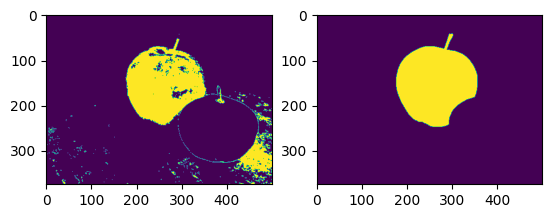

In [843]:
plt.subplot(1, 2, 1)
plt.imshow(np.where(probs[2] > t_s[F_idx], 1, 0))
plt.subplot(1, 2, 2)
plt.imshow(test_masks[0])

The shape of the ROC curve indicates that our classifier is a fairly good model for determining apple vs. non-apple pixels in this test image. In general, the classification is mostly in line with the ideal mask besides certain portions of the desk surface near the lower right-hand corner of the image and small areas on the apple itself (In addition, it is natural for the classifier to be unable distinguish between the stalk of apples and other fruits since the stalks are mostly similar in appearance). Classifying with the threshold obtained from the ROC curve yielded much more false positives than false negatives. Whereas by maximizing the F measure, the output obtained generated fewer false positives at the expense of more false positives.

## Part E

## Loading Images/Masks

Assuming apples are in a directory named partE_apples and masks are in a directory named partE_masks

In [768]:
part_e_apples = glob.glob("partE_apples/*.jpg")
part_e_masks = glob.glob("partE_masks/*.png")

new_apples = []
new_masks = []

# imgs shrunk to reduce processing time
for myFile in part_e_apples:
    im = plt.imread(myFile)
    h, w = im.shape[0:2]
    h = int(h*0.5)
    w = int(w*0.5)
    im = cv2.resize(im, (w, h), interpolation = cv2.INTER_AREA)
    new_apples.append(im)
for myFile in part_e_masks:
    im = plt.imread(myFile)
    h, w = im.shape[0:2]
    h = int(h*0.5)
    w = int(w*0.5)
    im = cv2.resize(im, (w, h), interpolation = cv2.INTER_AREA)
    new_masks.append(im)

In [769]:
# turn RGB images from 0-255 to 0-1
for i in range(len(new_apples)):
    new_apples[i] = new_apples[i].astype(np.float32) / 255.

# form masks of 0s and 1s
for i in range(len(new_masks)):
    new_masks[i] = np.where(new_masks[i][:,:,2] > 0.5, 1, 0)

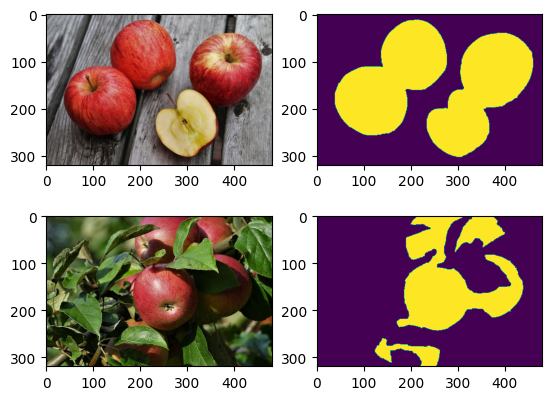

In [771]:
plt.subplot(2, 2, 1)
plt.imshow(new_apples[0])
plt.subplot(2, 2, 2)
plt.imshow(new_masks[0])
plt.subplot(2, 2, 3)
plt.imshow(new_apples[1])
plt.subplot(2, 2, 4)
plt.imshow(new_masks[1])

In [775]:
new_probs = []
for new_apple in new_apples:
    prob = np.zeros([new_apple.shape[0], new_apple.shape[1]])
    for i in range(new_apple.shape[0]):
        for j in range(new_apple.shape[1]):
            prob_1 = getMixGaussProb(new_apple[i,j,:],mixGaussEst_1)
            prob[i, j] = prob_1
    new_probs.append(prob)

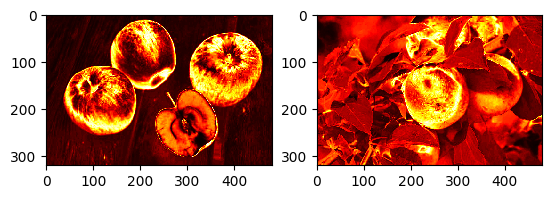

In [776]:
plt.subplot(1, 2, 1)
plt.imshow(new_probs[0], cmap='hot', interpolation='nearest')
plt.subplot(1, 2, 2)
plt.imshow(new_probs[1], cmap='hot', interpolation='nearest')

## Image 1

In [785]:
t_s = (np.arange(40)) / 40
X = []
Y = []
TPs = []
TNs = []
FPs = []
FNs = []
for t in t_s:
    TP, TN, FP, FN, ROC_Y, ROC_X = count_stats(new_probs[0], new_masks[0], t)
    X.append(ROC_X)
    Y.append(ROC_Y)
    TPs.append(TP)
    TNs.append(TN)
    FPs.append(FP)
    FNs.append(FN)

### Change of True Positives/True Negatives/False Positives/False Negatives with threshold t

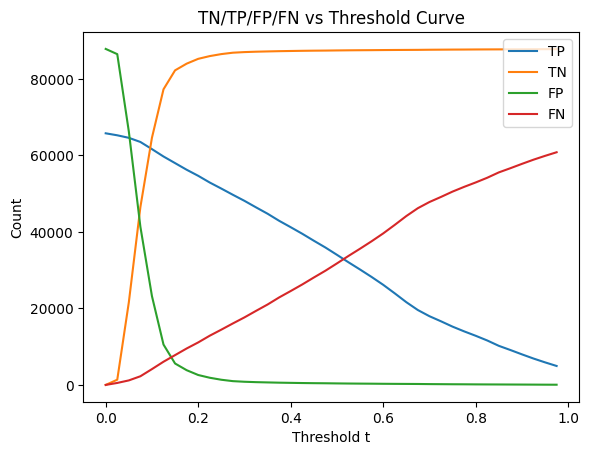

In [787]:
fig,ax = plt.subplots(1)
ax.plot(t_s, TPs, label="TP")
ax.plot(t_s, TNs, label="TN")
ax.plot(t_s, FPs, label="FP")
ax.plot(t_s, FNs, label="FN")
plt.legend(loc="upper right")
plt.title("TN/TP/FP/FN vs Threshold Curve")
plt.xlabel("Threshold t")
plt.ylabel("Count")
plt.show()

### Finding Optimal Threshold t on ROC Curve

In [789]:
# if we weigh false positive and false negative rate equally
idx = np.argmax(np.array(Y) - np.array(X))
print('Optimal t (approximate):', t_s[idx])

Optimal t (approximate): 0.15


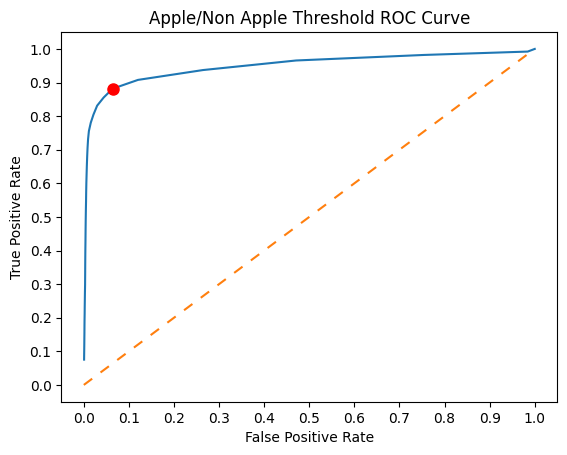

In [790]:
fig,ax = plt.subplots(1)
ax.plot(X, Y)
ticks = list(np.arange(11) / 10)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.plot([0, 1], [0, 1], linestyle='--', dashes=(5, 5))
plt.title("Apple/Non Apple Threshold ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot(X[idx], Y[idx], marker="o", markersize=8, markeredgecolor="red", markerfacecolor="red")
plt.show()

### Confusion Matrix & F Measure of ROC Optimal Threshold t

In [795]:
# stats using optimal t from ROC curve
TP, TN, FP, FN, ROC_Y, ROC_X = count_stats(new_probs[0], new_masks[0], t_s[idx])
CF = [[TN, FP], [FN, TP]]
precision = TP/(TP+FP)
recall = TP/(TP+FN)
F = 2 * (precision * recall) / (precision + recall)
print('confusion matrix:', CF)
print('F measure:', F)

confusion matrix: [[82229, 5600], [7791, 57980]]
F measure: 0.8964754814419679


### Optimal Threshold t by Optimizing F Meausre

In [796]:
# attempt to find t by maximizing F measure instead
TPs = np.array(TPs)
FPs = np.array(FPs)
precisions = TPs/(TPs+FPs+1e-6)
recalls = TPs/(TPs+FNs+1e-6)
Fs = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)
F_idx = np.argmax(Fs)
print('Optimal t (approximate):', t_s[F_idx])

Optimal t (approximate): 0.15


### Confusion Matrix at Optimal F Measure

In [797]:
# stats using t from maximizing F measure
TP, TN, FP, FN, ROC_Y, ROC_X = count_stats(new_probs[0], new_masks[0], t_s[F_idx])
CF = [[TN, FP], [FN, TP]]
precision = TP/(TP+FP)
recall = TP/(TP+FN)
F = 2 * (precision * recall) / (precision + recall)
print('confusion matrix:', CF)
print('F measure:', F)

confusion matrix: [[82229, 5600], [7791, 57980]]
F measure: 0.8964754814419679


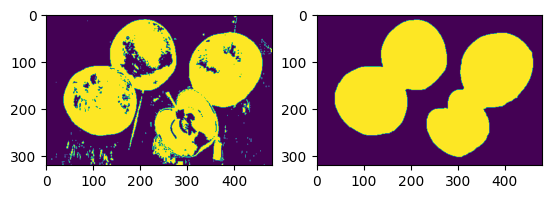

In [801]:
plt.subplot(1, 2, 1)
plt.imshow(np.where(new_probs[0] > t_s[F_idx], 1, 0))
plt.subplot(1, 2, 2)
plt.imshow(new_masks[0])

The performance of the model on this test image is similar to the previous provided test image. The shape of the ROC curve indicates that the model is a fairly good fit for predicting apple vs. non-apple pixels in the provided test image. The outcome is mostly correct besides certain small areas on the apples and certain sections of the background surface. In this case, the optimal threshold obtained from the ROC curve also yielded the highest F measure. The number of false positives and false negatives in the result is fairly acceptable.

## Image 2

In [800]:
t_s = (np.arange(40)) / 40
X = []
Y = []
TPs = []
TNs = []
FPs = []
FNs = []
for t in t_s:
    TP, TN, FP, FN, ROC_Y, ROC_X = count_stats(new_probs[1], new_masks[1], t)
    X.append(ROC_X)
    Y.append(ROC_Y)
    TPs.append(TP)
    TNs.append(TN)
    FPs.append(FP)
    FNs.append(FN)

### Change of True Positives/True Negatives/False Positives/False Negatives with threshold t

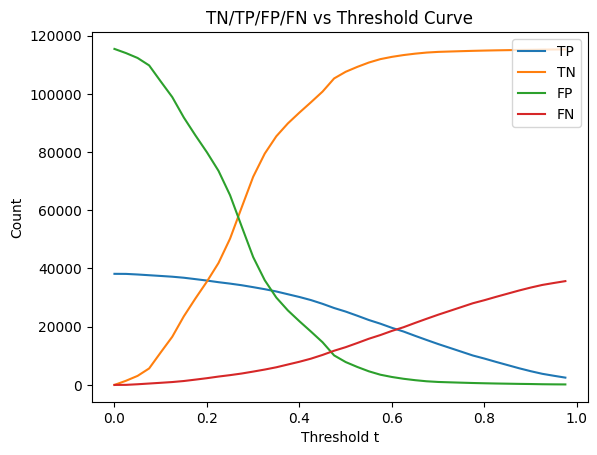

In [802]:
fig,ax = plt.subplots(1)
ax.plot(t_s, TPs, label="TP")
ax.plot(t_s, TNs, label="TN")
ax.plot(t_s, FPs, label="FP")
ax.plot(t_s, FNs, label="FN")
plt.legend(loc="upper right")
plt.title("TN/TP/FP/FN vs Threshold Curve")
plt.xlabel("Threshold t")
plt.ylabel("Count")
plt.show()

### Finding Optimal Threshold t on ROC Curve

In [804]:
# if we weigh false positive and false negative rate equally
idx = np.argmax(np.array(Y) - np.array(X))
print('Optimal t (approximate):', t_s[idx])

Optimal t (approximate): 0.425


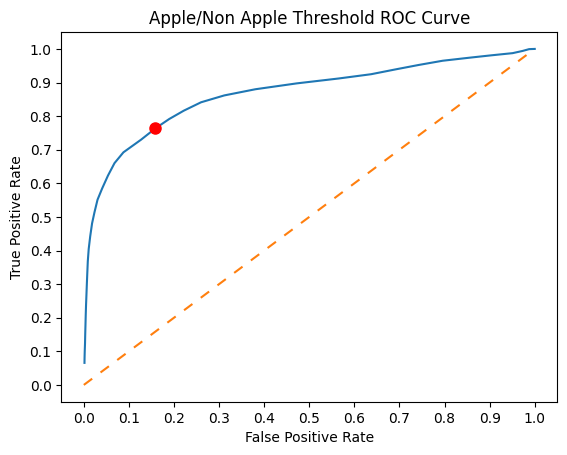

In [805]:
fig,ax = plt.subplots(1)
ax.plot(X, Y)
ticks = list(np.arange(11) / 10)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.plot([0, 1], [0, 1], linestyle='--', dashes=(5, 5))
plt.title("Apple/Non Apple Threshold ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot(X[idx], Y[idx], marker="o", markersize=8, markeredgecolor="red", markerfacecolor="red")
plt.show()

### Confusion Matrix & F Measure of ROC Optimal Threshold t

In [810]:
# stats using optimal t from ROC curve
TP, TN, FP, FN, ROC_Y, ROC_X = count_stats(new_probs[1], new_masks[1], t_s[idx])
CF = [[TN, FP], [FN, TP]]
precision = TP/(TP+FP)
recall = TP/(TP+FN)
F = 2 * (precision * recall) / (precision + recall)
print('confusion matrix:', CF)
print('F measure:', F)

confusion matrix: [[97120, 18314], [9026, 29140]]
F measure: 0.6806820836253211


### Optimal Threshold t by Optimizing F Meausre

In [811]:
# attempt to find t by maximizing F measure instead
TPs = np.array(TPs)
FPs = np.array(FPs)
precisions = TPs/(TPs+FPs+1e-6)
recalls = TPs/(TPs+FNs+1e-6)
Fs = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)
F_idx = np.argmax(Fs)
print('Optimal t (approximate):', t_s[F_idx])

Optimal t (approximate): 0.5


### Confusion Matrix at Optimal F Measure

In [812]:
# stats using t from maximizing F measure
TP, TN, FP, FN, ROC_Y, ROC_X = count_stats(new_probs[1], new_masks[1], t_s[F_idx])
CF = [[TN, FP], [FN, TP]]
precision = TP/(TP+FP)
recall = TP/(TP+FN)
F = 2 * (precision * recall) / (precision + recall)
print('confusion matrix:', CF)
print('F measure:', F)

confusion matrix: [[107578, 7856], [12970, 25196]]
F measure: 0.7075739279395659


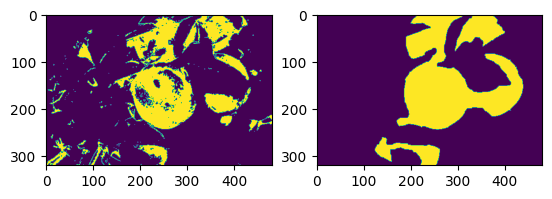

In [814]:
plt.subplot(1, 2, 1)
plt.imshow(np.where(new_probs[1] > t_s[F_idx], 1, 0))
plt.subplot(1, 2, 2)
plt.imshow(new_masks[1])